# Nombre: Felipe Morales

# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [1]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 238MB/s]


'blood.zip'

In [3]:
# Descomprimimos el dataset
!unzip blood.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_5029.jpeg  
 

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

# Funciones Auxiliares

In [4]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from sklearn import metrics
import matplotlib.pyplot as plt

In [5]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, device, iterator, train_transforms, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device).float() #Data
    y = y.long().to(device) #Labels

    if train_transforms:
      x = train_transforms(x)

    y_one_hot = torch.nn.functional.one_hot(y, num_classes=4).float()
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data

    y_pred_class = torch.argmax(y_pred, dim=1)

    loss = criterion(y_pred, y_one_hot) #Compute the loss
       
    acc = calculate_accuracy(y_pred_class, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, device, iterator, eval_transforms, criterion):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device).float()
      y = y.long().to(device)

      if eval_transforms:
        x = eval_transforms(x)

      y_one_hot = torch.nn.functional.one_hot(y, num_classes=4).float()

      y_pred= model(x)

      y_pred_class = torch.argmax(y_pred, dim=1)

      loss = criterion(y_pred, y_one_hot)

      acc = calculate_accuracy(y_pred_class, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, device, optimizer, train_transforms, eval_transforms, train_loader, val_loader, test_loader, epochs, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  best_valid_acc = float('-inf')

  for epoch in range(epochs):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, device, train_loader, train_transforms, optimizer, criterion)
    valid_loss, valid_acc = evaluate(network, device, val_loader, eval_transforms, criterion)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, device, test_loader, eval_transforms, criterion)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

#Function to get predictions over a dataset

def get_predictions(model, iterator, device, eval_transform):

    #For prediction, we also deactivate training features
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (data, target) in iterator:
            #data = data.to(device)
            data = data.to(device).float()
            target = target.long().to(device)
            if eval_transform: # ?
              data = eval_transform(data)
            y_pred = model(data)

            #Remember that our network does not apply the softmax
            #We have to do it explicitly for prediction
            #y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_pred.argmax(1, keepdim = True)
            y_pred_class = torch.argmax(y_pred, dim=1)

            #We store the images, their labels and the pdf of each sample
            #images.append(x.cpu())
            labels.append(target.cpu())
            probs.append(y_pred.cpu())

    #images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

#Plot a confussion matrix
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

# Datasets

In [6]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam

class PadToSquare(object):
    def __init__(self, fill=0):
        self.fill = fill
        
    def __call__(self, image):
        if isinstance(image, torch.Tensor):
            _, height, width = image.shape
        else:
            width, height = image.size
        l_pad, t_pad, r_pad, b_pad = 0, 0, 0, 0
        if height < width:
            t_pad = int((width-height)/2)
            b_pad = (width-height)-t_pad
        elif width < height:
            l_pad = int((height-width)/2)
            r_pad = (height-width)-l_pad
        image = T.functional.pad(image, (l_pad, t_pad, r_pad, b_pad), fill=self.fill)
        return image

class ScaleBetweenZeroOne(object):
  def __call__(self, image):
    return image / 255.

transform_train = T.Compose([
    T.PILToTensor(),
    PadToSquare(),
    ScaleBetweenZeroOne(),
    T.Resize((224, 224)),
])

transform_eval = T.Compose([
    T.PILToTensor(),
    PadToSquare(),
    ScaleBetweenZeroOne(),
    T.Resize((224, 224)),
])

train_dataset = torchvision.datasets.ImageFolder('./images/TRAIN', transform=transform_train)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
)

val_dataset = torchvision.datasets.ImageFolder('./images/VAL', transform=transform_eval)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=False,
)

test_dataset = torchvision.datasets.ImageFolder('./images/TEST', transform=transform_eval)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=True,
)

In [ ]:
from collections import Counter
print("Balance de clases para train_dataset:")
print(dict(Counter(train_dataset.targets)))
print("Balance de clases para val_dataset:")
print(dict(Counter(val_dataset.targets)))
print("Balance de clases para test_dataset:")
print(dict(Counter(test_dataset.targets)))

print(test_dataset.class_to_idx)

Balance de clases para train_dataset:
{0: 2497, 1: 2483, 2: 2478, 3: 2499}
Balance de clases para val_dataset:
{0: 13, 1: 6, 2: 4, 3: 48}
Balance de clases para test_dataset:
{0: 623, 1: 620, 2: 620, 3: 624}
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


# Entrenamiento

In [7]:
iniciar_semillas(1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

eval_transforms = T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

# model = resnet18(weights=ResNet18_Weights.DEFAULT, progress=False)
# model.fc = nn.Linear(512, 4)
# train_transforms = ResNet18_Weights.DEFAULT.transforms()

# model = alexnet(weights=AlexNet_Weights.DEFAULT, progress=False)
# model.classifier[6] = nn.Linear(4096, 4)
# train_transforms = AlexNet_Weights.DEFAULT.transforms()

model = resnet50(weights=ResNet50_Weights.DEFAULT, progress=False)
model.fc = nn.Linear(2048, 4)
train_transforms = ResNet50_Weights.DEFAULT.transforms()

optim = Adam(model.parameters(), lr=1e-03)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


In [8]:
train_complete(model, device, optim, train_transforms, eval_transforms, train_loader, val_loader, test_loader, 20, 'test')

Epoch: 01 | Epoch Time: 2m 21s
	Train Loss: 0.192 | Train Acc: 92.24%
	 Val. Loss: 0.571 |  Val. Acc: 85.92%
Epoch: 02 | Epoch Time: 2m 20s
	Train Loss: 0.042 | Train Acc: 98.48%
	 Val. Loss: 1.220 |  Val. Acc: 85.92%
Epoch: 03 | Epoch Time: 2m 21s
	Train Loss: 0.032 | Train Acc: 98.94%
	 Val. Loss: 1.808 |  Val. Acc: 85.92%
Epoch: 04 | Epoch Time: 2m 21s
	Train Loss: 0.016 | Train Acc: 99.55%
	 Val. Loss: 0.703 |  Val. Acc: 87.32%
Epoch: 05 | Epoch Time: 2m 21s
	Train Loss: 0.028 | Train Acc: 99.14%
	 Val. Loss: 0.938 |  Val. Acc: 76.06%
Epoch: 06 | Epoch Time: 2m 21s
	Train Loss: 0.023 | Train Acc: 99.15%
	 Val. Loss: 1.448 |  Val. Acc: 85.92%
Epoch: 07 | Epoch Time: 2m 21s
	Train Loss: 0.039 | Train Acc: 98.91%
	 Val. Loss: 0.599 |  Val. Acc: 87.32%
Epoch: 08 | Epoch Time: 2m 20s
	Train Loss: 0.019 | Train Acc: 99.37%
	 Val. Loss: 0.923 |  Val. Acc: 80.28%
Epoch: 09 | Epoch Time: 2m 21s
	Train Loss: 0.005 | Train Acc: 99.85%
	 Val. Loss: 1.362 |  Val. Acc: 81.69%
Epoch: 10 | Epoch T

# Análisis y conclusiones

Para manejar las imagenes se realizan una serie de transformaciones para centrar la imagen dentro de las cuales se tiene PadToSquare donde para cada imagen se deja como un cuadrado y ScaleBetweenZeroOne para normalizar los valores.

En cuanto a la red, se utiliza una red ResNet con 50 capas convolucionales con fine tunning donde para la capa final o clasificadora se define una la cual tiene un input de 2048 neuronas y una salida de 4 neuronas que corresponden a las clases del dataset.

También se utilizaron otras redes como una resnet con 18 capas convolucionales y otra como lo es alexnet. Los resultados respecto al accuracy se presentan en la siguiente tabla.

| Red | Test acc |
| :-- | --: |
| Resnet18 | 85.00% |
| AlexNet | 25.07% |
| ResNet50 | 85.20% |

En cuanto a los datasets es posible notar que existe un desbalance de clases considerable para val_dataset, donde aquellas imagenes de la clase Neutrophil son más del doble que las otras clases. Frente a esto una opción es volver a juntar los datos y luego separar por train, val y test balanceando las clases.

A continuación se presenta la matriz de confusión y algunas métricas para el conjunto de test.

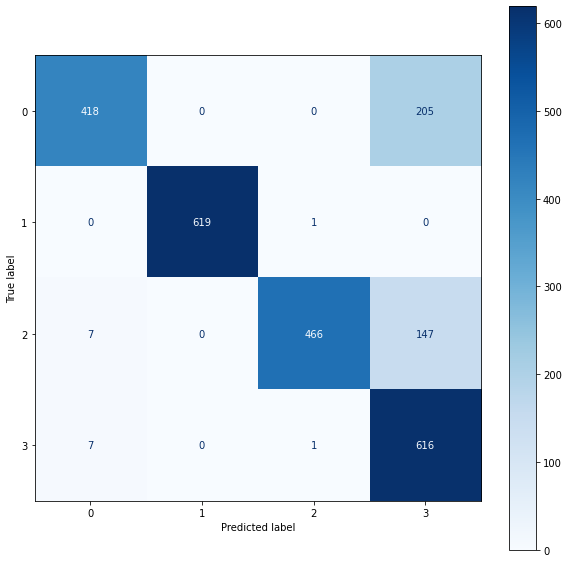

In [ ]:
#Comute predictions and the label with the maximum probability
labels, probs = get_predictions(model, test_loader, device, eval_transforms)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)

In [ ]:
print(metrics.classification_report(labels, pred_labels, digits=5))

              precision    recall  f1-score   support

           0    0.96759   0.67095   0.79242       623
           1    1.00000   0.99839   0.99919       620
           2    0.99573   0.75161   0.85662       620
           3    0.63636   0.98718   0.77387       624

    accuracy                        0.85203      2487
   macro avg    0.89992   0.85203   0.85552      2487
weighted avg    0.89958   0.85203   0.85532      2487



Se puede observar tanto de la matriz como de las métricas que la red entrega resultados incorrectos principalmente cuando se trata de una imagen de la clase $0$ donde en ocaciones la clasifica como una de la clase $3$, y así también cuando se tiene una imagen de la clase $2$ y se clasifica como una de la clase $3$.

Dado que son muestreos médicos, los falsos positivos y falsos negativos son cruciales en el sentido que no se desea diagnosticar a una persona con algo que no tiene, entoces el 'f1-score' es la métrica la cual se busca estudiar y optimizar.